<a href="https://colab.research.google.com/github/Isi2000/PATTERN/blob/main/PATTERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#data an and plotting 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import random

#torch 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as Ft

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim

#working with dirs
import os

In [2]:
#this line of code copies the files in the PATTERN repo
#they are hd image so it may take a while
!git clone https://github.com/Isi2000/PATTERN.git

Cloning into 'PATTERN'...
remote: Enumerating objects: 5875, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 5875 (delta 6), reused 3 (delta 0), pack-reused 5830
Receiving objects: 100% (5875/5875), 1.13 GiB | 16.90 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (5859/5859), done.


# DATASET

First the image paths and labels need to be storged in a pd DataFrame object to later be put in a custom made dataset 

In [3]:
labels_map = {0: 'NORMAL', 1:'BACTERIAL', 2:'VIRAL',}

data_dir_train = '/content/PATTERN/images/t_all'
data_dir_test = '/content/PATTERN/images/test_all'
data_dir_val = '/content/PATTERN/images/val_all'

d_train = {'img_path': os.listdir(data_dir_train)}
d_test = {'img_path': os.listdir(data_dir_test)}
d_val = {'img_path': os.listdir(data_dir_val)}

df_train = pd.DataFrame(d_train)
df_test= pd.DataFrame(d_test)
df_val = pd.DataFrame(d_val)

df_train['label'] = 0
df_test['label'] = 0
df_val['label'] = 0

#these lines work really well, BE CAREFUL BECAUSE IT GIVES A PD WARNING 

#DIOCANE
df_train.loc[df_train['img_path'].str.contains('virus'), 'label'] = 2
df_train.loc[df_train['img_path'].str.contains('bacte'), 'label'] = 1
df_test.loc[df_test['img_path'].str.contains('virus'), 'label'] = 2
df_test.loc[df_test['img_path'].str.contains('bacte'), 'label'] = 1
df_val.loc[df_val['img_path'].str.contains('virus'), 'label'] = 2
df_val.loc[df_val['img_path'].str.contains('bacte'), 'label'] = 1

print(df_train.head())
print(df_test.head())
print(df_val.head())


                       img_path  label
0      person408_virus_815.jpeg      2
1             IM-0191-0001.jpeg      0
2     person721_virus_1340.jpeg      2
3  person783_bacteria_2687.jpeg      1
4  person321_bacteria_1483.jpeg      1
                         img_path  label
0          person21_virus_53.jpeg      2
1       NORMAL2-IM-0376-0001.jpeg      0
2       NORMAL2-IM-0141-0001.jpeg      0
3  NORMAL2-IM-0173-0001-0001.jpeg      0
4       NORMAL2-IM-0315-0001.jpeg      0
                        img_path  label
0  person1951_bacteria_4882.jpeg      1
1  person1949_bacteria_4880.jpeg      1
2      NORMAL2-IM-1442-0001.jpeg      0
3      NORMAL2-IM-1440-0001.jpeg      0
4      NORMAL2-IM-1438-0001.jpeg      0


Transformation and Custome Image Dataset. The class is written following to pytorch standards 
(for more info see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [4]:
#stands for pixels, it's for resizing

pix = 224

transform_1 = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Grayscale(),    
     #the resizing must be fixed according to training perf
     #224 is the standard size for resnets
     transforms.Resize(size = (pix, pix), antialias = False),
     transforms.Normalize(mean=[0.0], std=[1.0]),
     #this one is for resnet
     transforms.Lambda(lambda x: x.repeat(3,1,1)),
     ])

class CustomImageDataset(Dataset):
    def __init__(self, pd_df, img_dir, transform=None, target_transform=None):
        self.img_labels = pd_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_ = CustomImageDataset(df_train, data_dir_train, transform = transform_1)
test_ = CustomImageDataset(df_test, data_dir_test, transform = transform_1)
val_ = CustomImageDataset(df_val, data_dir_val, transform = transform_1)

Data visualization of the dataset

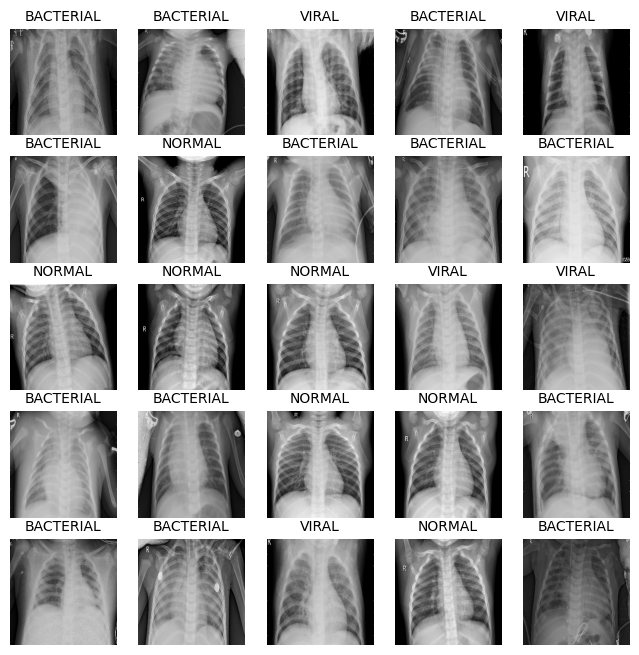

In [5]:
def plotter(data):      
    """this plots 9 images from a dataset"""
    figure = plt.figure(figsize = (8,8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = Ft.to_pil_image(data[sample_idx][0]) , data[sample_idx][1]
        #print(img.size)
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.title(labels_map[label], fontsize = 10)
        plt.imshow(img)        
    plt.show()

plotter(train_)

# Neural Network and GPU

The code below tells the program to use gpu if available. All the code written is designed to work even if the machine doesn't have a gpu

In [6]:
if torch.cuda.is_available():
    print("Congratulations, you have a GPU!")
else:
    print("PyTorch cannot see your GPU :(")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Congratulations, you have a GPU!


# Resnet
The Neural Network chosen is resnet50. It is a pretrained NN that performs really well on computer vision problem. It takes as input 3 channels 224x224 images and it classifies them into 1000 classes

In [7]:
from torchvision.models import googlenet

net = googlenet(num_classes = 3,pretrained=False, aux_logits=False ).to(torch.device('cuda'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


The input channels can be fixed with a simple transformation. For what concerns the output, the output of the net can be connected to a fully connected layer with label 3 outputs

In [8]:
summary(net, (3, pix, pix), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

# Training and Testing

In [9]:

loss_fn = torch.nn.CrossEntropyLoss()
m = nn.LogSoftmax(dim=1)

#Adam may be too strong
optimizer = optim.AdamW(net.parameters(), lr=5e-7, weight_decay=1e-5)

train_loader = DataLoader(train_, batch_size=50, shuffle=True, num_workers = 2)
test_loader = DataLoader(test_, batch_size=50, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_, batch_size=10, shuffle=True)



def train(model, device, train_loader, optimizer, epoch, freq=20):
    model.train()
    epoch_loss = 0    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(m(output), target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % freq == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
        
        epoch_loss += loss.item()
            
    return epoch_loss / len(train_loader)


def test(model, device, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(m(output), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

# LOSS

NOTE: as suggested by karphaty it is always usefull to check inital loss.
With softmax and 3 classes we expect initial loss to be around -ln(0.33) = 1.1, this is fully compatible with what we observe with a pretrained net

In [10]:
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 15
best_params = net.state_dict()
best_accuracy = 0

test_accuracy = 0
epoch = 0
while test_accuracy < 85:
    print('Train Epoch: {}'.format(epoch))
    train_losses.append(train(net, device, train_loader, optimizer, epoch))
    test_loss, test_accuracy = test(net, device, test_loader)
    epoch = epoch + 1
    print(test_accuracy)

    # model selection
    if test_accuracy >= best_accuracy:
        best_accuracy = test_accuracy
        best_params = net.state_dict()

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Train Epoch: 0
Train Epoch: 0 [0/5216 (0%)]	Loss: 1.095253
Train Epoch: 0 [1000/5216 (19%)]	Loss: 1.103929
Train Epoch: 0 [2000/5216 (38%)]	Loss: 1.084382
Train Epoch: 0 [3000/5216 (57%)]	Loss: 1.065915
Train Epoch: 0 [4000/5216 (76%)]	Loss: 1.032637
Train Epoch: 0 [5000/5216 (95%)]	Loss: 1.031638

Test set: Average loss: 1.0337, Accuracy: 384/624 (62%)

61.53846153846154
Train Epoch: 1
Train Epoch: 1 [0/5216 (0%)]	Loss: 1.029877
Train Epoch: 1 [1000/5216 (19%)]	Loss: 1.025919
Train Epoch: 1 [2000/5216 (38%)]	Loss: 0.993087
Train Epoch: 1 [3000/5216 (57%)]	Loss: 1.032392
Train Epoch: 1 [4000/5216 (76%)]	Loss: 0.946205
Train Epoch: 1 [5000/5216 (95%)]	Loss: 0.919773

Test set: Average loss: 0.9714, Accuracy: 397/624 (64%)

63.62179487179487
Train Epoch: 2
Train Epoch: 2 [0/5216 (0%)]	Loss: 0.980192
Train Epoch: 2 [1000/5216 (19%)]	Loss: 0.946207
Train Epoch: 2 [2000/5216 (38%)]	Loss: 0.880477
Train Epoch: 2 [3000/5216 (57%)]	Loss: 1.015781
Train Epoch: 2 [4000/5216 (76%)]	Loss: 0.861635

KeyboardInterrupt: ignored

# RESULTS

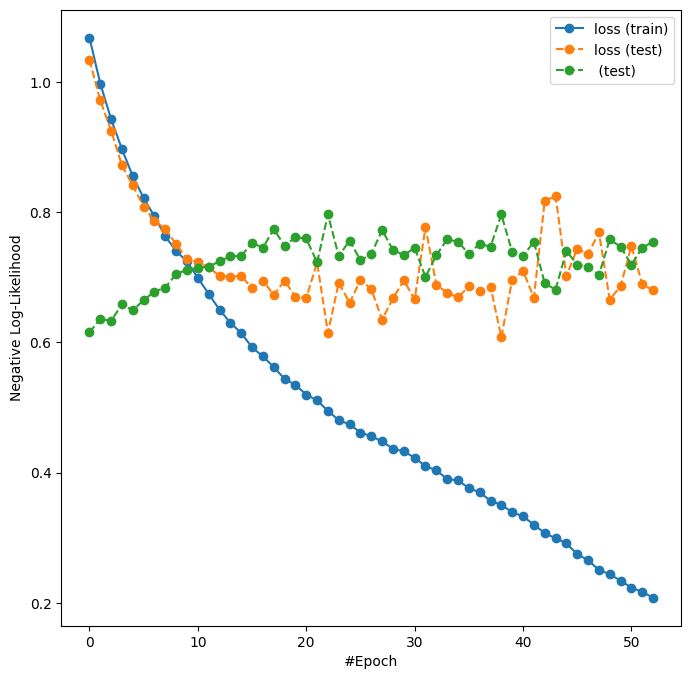

In [11]:

plt.figure(figsize=(8, 8))
a = []
for i in test_accuracies:
  a.append(i / 100)

plt.plot(train_losses, marker='o', label='loss (train)')
plt.plot(test_losses, marker='o', linestyle='dashed', label='loss (test)')
plt.plot(a, marker='o', linestyle='dashed', label=' (test)')



plt.xlabel('#Epoch')
plt.ylabel('Negative Log-Likelihood')

plt.legend()
plt.show()


In [12]:
# resume best model
net.load_state_dict(best_params)
best_accuracy

79.6474358974359

In [13]:
#since this validaion is basically additional testing I think I can keep the same function
test(net, device , val_loader )
#this tells me that there might me something fishy


Test set: Average loss: 0.8986, Accuracy: 10/16 (62%)



(0.8985783755779266, 62.5)